In [1]:
import json
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.cm as cm
import numpy as np
import pandas as pd

/tmp/ipykernel_278329/2467023303.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Obtain Dice results
with open('/home/t722s/Desktop/Sam-Med3DTest/BratsMiniOld/multi_run_results_original.json', 'r') as f:
    original = json.load(f)

with open('/home/t722s/Desktop/Sam-Med3DTest/BratsMini/gt_crop_interactive.json', 'r') as f:
    gt_i = json.load(f)

with open('/home/t722s/Desktop/Sam-Med3DTest/BratsMini/gt_crop_not_interactive.json', 'r') as f:
    gt_not_i = json.load(f)

with open('/home/t722s/Desktop/Sam-Med3DTest/BratsMini/point_crop_interactive.json', 'r') as f:
    pt_i = json.load(f)

with open('/home/t722s/Desktop/Sam-Med3DTest/BratsMini/point_crop_not_interactive.json', 'r') as f:
    pt_not_i = json.load(f)

dice_arrays = {
    'original':     np.array([v['dice'] for v in original.values()]).T,
    'gt_i':  np.array([v['dice'] for v in gt_i.values()]).T,
    'gt_not_i':  np.array([v['dice'] for v in gt_not_i.values()]).T,
    'pt_i':  np.array([v['dice'] for v in pt_i.values()]).T,
    'pt_not_i':  np.array([v['dice'] for v in pt_not_i.values()]).T,
}


FileNotFoundError: [Errno 2] No such file or directory: '/home/t722s/Desktop/Sam-Med3DTest/BratsMiniOld/multi_run_results_original.json'

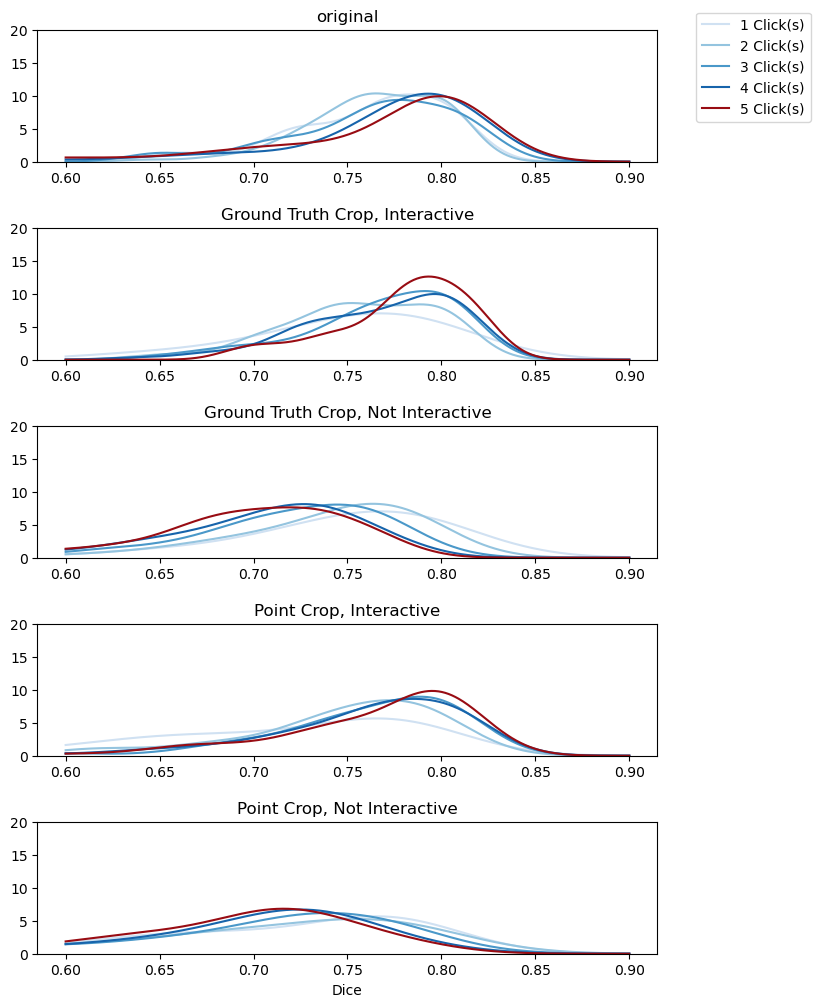

In [ ]:
# Common plotting elements
num_rows = 5
x_range = np.linspace(0.6, 0.9, 500)
color_start = 0.2  # Start from a darker shade
color_end = 1  # End before the darkest shade to keep a uniform intensity
colors = [cm.Blues(i / (num_rows-1) * (color_end - color_start) + color_start) for i in range(num_rows-1)]
colors.append(cm.Reds(0.9))
protocol_names = {
    'original': 'original',
    'gt_i':     'Ground Truth Crop, Interactive',
    'gt_not_i': 'Ground Truth Crop, Not Interactive',
    'pt_i':     'Point Crop, Interactive',
    'pt_not_i': 'Point Crop, Not Interactive',
}

fig, ax = plt.subplots(5,1, figsize = (8,12))
plt.subplots_adjust(hspace=0.5, right=0.9)


for i, (protocol, ar) in enumerate(dice_arrays.items()):
    for j, row in enumerate(ar):
        kde = gaussian_kde(row)
        kde_values = kde(x_range)
        
        # Plot each row's KDE with a different color
        ax[i].plot(x_range, kde_values, color=colors[j], label=f'{j+1} Click(s)')

    ax[i].set_title(protocol_names[protocol])
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    ax[i].set_ylim([0,20])

    if i == 0: 
        fig.legend(loc = 'upper right', bbox_to_anchor=(1.1, 0.9))

ax[4].set_xlabel('Dice')
plt.show()


In [ ]:

summary = dict()
df = pd.DataFrame(columns = ['protocol', 'n clicks', 'min', '1st', 'med', 'mean', '3rd', 'std'])
for protocol, ar in dice_arrays.items():
    summary[protocol] = dict()
    for i, row in enumerate(ar):
        d = dict()
        d = {
            'protocol': protocol_names[protocol],
            'n clicks': i+1,
            'min': np.min(row),
            '1st': np.quantile(row, 0.25),
            'med': np.median(row),
            'mean': np.mean(row),
            '3rd': np.quantile(row, 0.75),
            'std': np.std(row)
        }
        df.loc[len(df)] = d
        summary[protocol][f'click{i+1}']=d

df = df.round(decimals=4)
#display(df)
display(df[df['n clicks']==5])

,protocol,n clicks,min,1st,med,mean,3rd,std
4,original,5,0.5652,0.7477,0.7894,0.7665,0.8061,0.0591
9,"Ground Truth Crop, Interactive",5,0.6900,0.7638,0.7876,0.7793,0.8054,0.0345
14,"Point Crop, Interactive",5,0.5717,0.7381,0.7808,0.7635,0.8012,0.0514
19,"Ground Truth Crop, Not Interactive",5,0.5353,0.6696,0.7049,0.6982,0.7379,0.0509
24,"Point Crop, Not Interactive",5,0.3952,0.6528,0.7030,0.6883,0.7327,0.0692


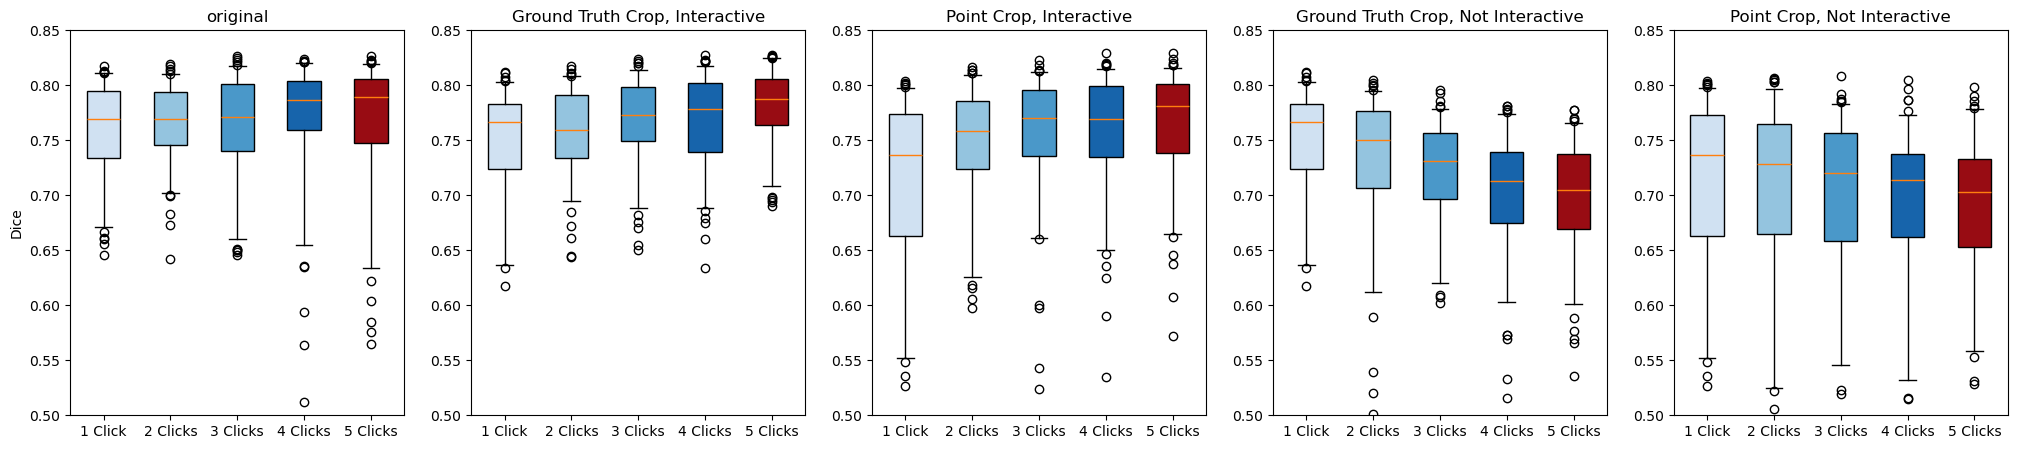

In [ ]:
fig, ax = plt.subplots(1,5, figsize = (25,5))
for i, (protocol, data) in enumerate(dice_arrays.items()):
    data = data.T
    box = ax[i].boxplot(data, whis=[5,95], patch_artist=True)

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set the x-axis labels
    ax[i].set_xticklabels(['1 Click', '2 Clicks', '3 Clicks', '4 Clicks', '5 Clicks'])

    # Adding title and labels
    ax[i].set_title(protocol_names[protocol])
    ax[i].set_ylim([0.5,0.85])
    ax[i].set_ylabel(None)
    if i == 0:
        ax[i].set_ylabel('Dice')

# Show the plot
plt.show()


In [ ]:
with open('/home/t722s/Desktop/Sam-Med3DTest/evalBrats/i_points_not_i.json', 'r') as f:
    i_pts = json.load(f)
diff = np.array([v['dice'] for v in gt_i.values()]).T - np.array([v['dice'] for v in i_pts.values()]).T
diff = diff[1:] # Remove 1 click entry. It's the same.

summary = dict()
df = pd.DataFrame(columns = ['n clicks', 'min', '1st', 'med', 'mean', '3rd', 'std'])

for i, row in enumerate(diff):
    d = dict()
    d = {
        'n clicks': i+2,
        'min': np.min(row),
        '1st': np.quantile(row, 0.25),
        'med': np.median(row),
        'mean': np.mean(row),
        '3rd': np.quantile(row, 0.75),
        'std': np.std(row)
    }
    df.loc[len(df)] = d

df = df.round(decimals=4)
display(df)

,n clicks,min,1st,med,mean,3rd,std
0,2,-0.0682,0.0084,0.0261,0.0318,0.0551,0.0428
1,3,-0.0486,0.0489,0.0764,0.0897,0.1356,0.0734
2,4,-0.0511,0.0662,0.1104,0.1120,0.1613,0.0706
3,5,-0.0186,0.0900,0.1457,0.1448,0.1911,0.0825


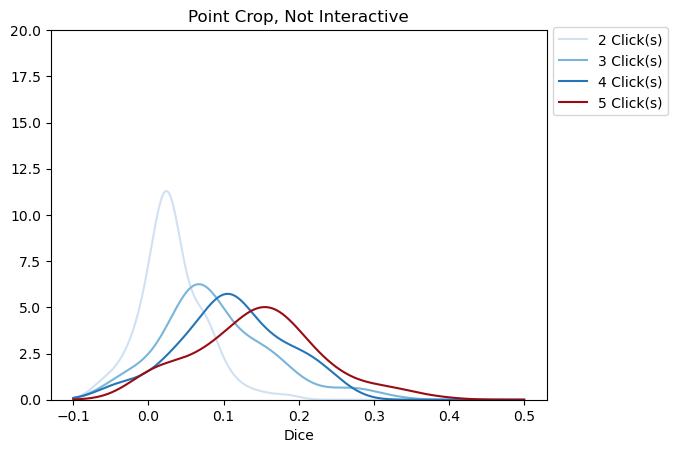

In [ ]:
# How much does the iterative approach matter vs the quality of good points? Comparison of protocols using interactive point method and just using points generated from an interactive method.
# Common plotting elements

num_rows = 4
x_range = np.linspace(-0.1, 0.5, 500)
colors = [cm.Blues(i / (num_rows-1) * (color_end - color_start) + color_start) for i in range(num_rows-1)]
colors.append(cm.Reds(0.9))

fig, ax = plt.subplots()
plt.subplots_adjust(hspace=0.5, right=0.9)

for j, row in enumerate(diff):
    kde = gaussian_kde(row)
    kde_values = kde(x_range)
    
    # Plot each row's KDE with a different color
    ax.plot(x_range, kde_values, color=colors[j], label=f'{j+2} Click(s)')

ax.set_title(protocol_names[protocol])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_ylim([0,20])

fig.legend(loc = 'upper right', bbox_to_anchor=(1.1, 0.9))

ax.set_xlabel('Dice')
plt.show()


0
1


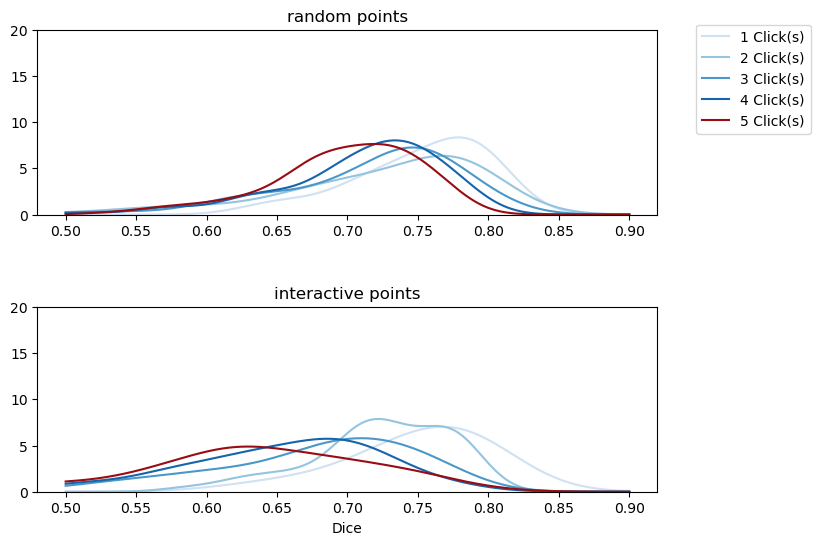

In [ ]:
dice_arrays = {
    'random points': np.array([v['dice'] for v in gt_not_i.values()]).T,
    'interactive points': np.array([v['dice'] for v in i_pts.values()]).T,
}

# Common plotting elements
num_rows = 5
colors = [cm.Blues(i / (num_rows-1) * (color_end - color_start) + color_start) for i in range(num_rows-1)]
colors.append(cm.Reds(0.9))
x_range = np.linspace(0.5, 0.9, 500)


fig, ax = plt.subplots(2,1, figsize = (8,6))
plt.subplots_adjust(hspace=0.5, right=0.9)


for i, (protocol, ar) in enumerate(dice_arrays.items()):
    print(i)
    for j, row in enumerate(ar):
        kde = gaussian_kde(row)
        kde_values = kde(x_range)
        
        # Plot each row's KDE with a different color
        ax[i].plot(x_range, kde_values, color=colors[j], label=f'{j+1} Click(s)')

    ax[i].set_title(protocol)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    ax[i].set_ylim([0,20])

    if i == 0: 
        fig.legend(loc = 'upper right', bbox_to_anchor=(1.1, 0.9))

ax[1].set_xlabel('Dice')
plt.show()
